In [1]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AaltoAtoms import get_perfect_circle_positions, minimize_manipulation_distance, lattice_discretize

from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg
import random

## Get scan from STM, get atom positions, program lateral manipulations (in order of labeling in figure) using GUI. 
This may require fine-tuning parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only surface features you want to see are registered in the image frame when you run the cell.

succeed to connect
	23 centroids


<IPython.core.display.Javascript object>


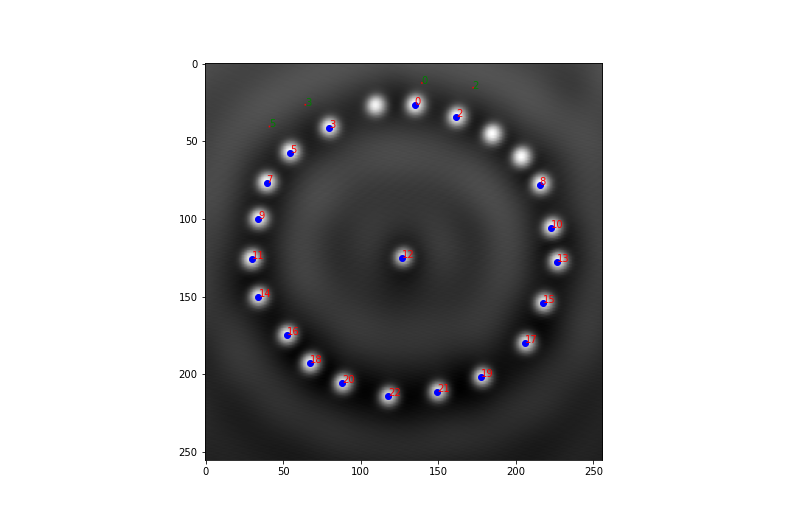

Textarea(value='[]', description='points:')

In [85]:
%matplotlib notebook
import pdb 
CC = Createc_Controller()

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
#C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)

centroids = C.centroids

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
sctr = plt.scatter(*np.array(centroids).T, color="blue")

# give numbers to atom positions
centroids_text = []
for n, c in enumerate(centroids):
    t = plt.text(*c,'%d' %(n), color='r')
    centroids_text.append(t)

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

removed = 0

# Function to run when a pixel is clicked
def onclick(event):
    print(help(event))
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    global sctr
    global centroids
    global centroids_text
    global removed 
    
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    # right click: 
    if event.button ==3:
        text_area.value = '%s click: button=%d' %('double' if event.dblclick else 'single', event.button)
        centroids.pop(index-removed)
        sctr.remove()
        centroids_text[index-removed].remove()
        centroids_text.pop(index-removed)
        plt.imshow(dispmat)
        sctr = plt.scatter(*np.array(centroids).T, color="blue")
        index += 1
        removed += 1
        return
    
    # left click: 
    if event.button == 1:

        if (y, x) in selected:
            im[y,x] = C.im[y,x]
            dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
            selected.remove((y, x))
        else:
            dispmat[y,x,:] = [1,0,0]
            selected += [(y, x)]
        text_area.value = str(selected)  # str(dir(event))
    
        
    print(selected)
    #plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Get location of corral center
If you recieve the error "Exception: something went wrong removing central atom" you can try to change the 'percentile' parameter in the previous cell.

In [59]:
len(centroids), len(C.centroids)

(20, 20)

	Max height guess different from Gaussian fit on average by: 1.14 Å
	 2022-04-25 15:58:35.621866
	Central atom from Naive fit:  5.9380757011946645 [127.90971835 120.5434111 ]
	Central atom from Gauss fit:  5.935050100230973 [126.74605493 119.28197014]


5.935050100230973

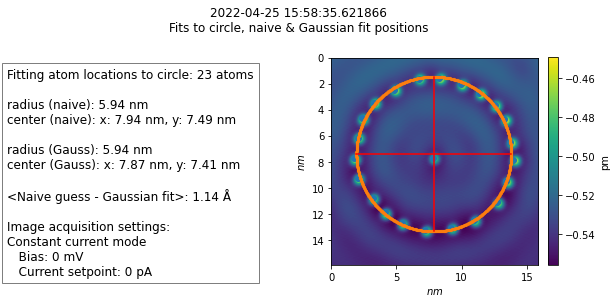

In [3]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1, savefig=False)

### Create 'perfect circle' set of data points
These have no alignment with the rest of the atoms except that the center is the same as the current corral.

Atom positions are also not lattice discretized, which becomes problematic for small corrals with dense walls. 

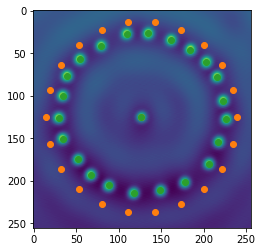

array([ 1.25987312, -3.8537863 ])

In [4]:
%matplotlib inline
radius_nm = 7

perfect_circle, center = get_perfect_circle_positions(radius_nm, C, True)
lattice_discretized_circle = lattice_discretize(perfect_circle, C.im.shape[0], C.xPix*C.ang_ppx_x/10.)
discretized_center = C.get_central_atom(lattice_discretized_circle)
center_to_discretized_center_difference = center - discretized_center
center_to_discretized_center_difference

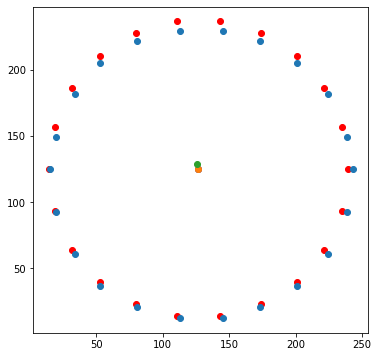

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(*perfect_circle.T, color="red")
plt.scatter(*(lattice_discretized_circle - discretized_center + center).T)
plt.scatter(*center)
plt.scatter(*discretized_center)

### Rotate 'perfect circle' to minimize manipulation distance
NB: Manipulations are programmed in software by referencing pixel coordinates in current scan frame. 

If scan frame is large (or pixel size too small), then manipulations won't be as accurate. Plan accordingly.

Manipulations done via remote access cannot occur outside of the current scan frame.

Watch out for potential collisions! These are not accounted for in the cell that does the actual manipulation, so for now you need to manually interrupt the notebook before a collision happens.

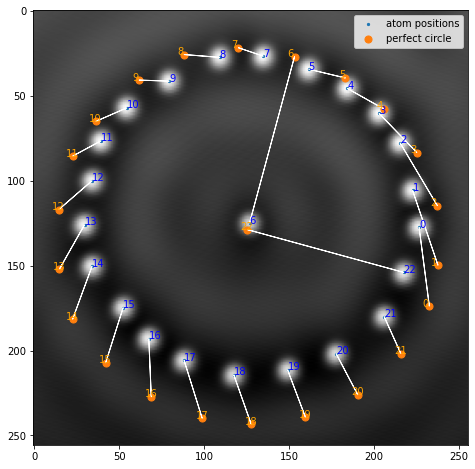

In [10]:
centroids_3D = minimize_manipulation_distance(CC, C, lattice_discretized_circle, discretized_center, dispmat)

In [285]:
# set lateral manipulation parameters
# note: for manipulation of Co atoms on Ag(111), better precision is achieved by using 10mV manipulation "regime" rather than 2.6V
latman_millivolt = 3 #5
latman_picoamp = 80000 #88000

# read tip offset and image size
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# bias for scanning (mV)
scan_bias_mv = 80

# for each "atom" in the image
for n in range(len(centroids_3D)):
    initial = pixel_to_nm(centroids_3D[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])

    dist_to_perfect = C.pix_to_nm(np.linalg.norm(np.array(applied_rotation[n])-np.array(centroids_3D[n])))
    if dist_to_perfect > 0.4: # nm 
        #print(centroids_3D[n], applied_rotation[n])
        im, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(dispmat);
        ax1.arrow(*centroids_3D[n], *(np.array(applied_rotation[n])-np.array(centroids_3D[n])), color='red')


        # documentation in AMRL/Environment/createc_control.py
        latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
        ax2.plot(latmandata.current)
        plt.show()
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()
# todo: plot and save data from these manipulations 

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run GUI notebook cell again and program lateral manipulations again using GUI.

3

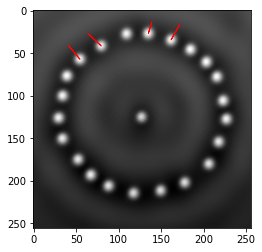

In [88]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
n_selected = min([len(centroids), len(selected)])
for n, c in enumerate(centroids[0:n_selected]):
    plt.arrow(*c, *(np.array(list(reversed(selected1[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()
#

## Carry out lateral manipulations in order 

In [75]:
# set the lateral manipulation parameters
latman_millivolt = 3
latman_picoamp = 80000
scan_bias_mv = 1000

offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids[0:])):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])), color="blue")
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
    
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()

NameError: name 'selected1' is not defined

In [46]:
latmandata.current

((-5.989805984540908e-09,),
 (-6.009425845832084e-09,),
 (-6.002574881591727e-09,),
 (-6.061551260927445e-09,),
 (-6.024415633021363e-09,),
 (-6.006525943291763e-09,),
 (-5.982178752361733e-09,),
 (-6.0235723076118575e-09,),
 (-6.090581816664553e-09,),
 (-5.984663431490844e-09,),
 (-6.059562185356526e-09,),
 (-5.966172889060317e-09,),
 (-6.019069687113188e-09,),
 (-6.126953167040483e-09,),
 (-5.898089572298204e-09,),
 (-6.085890902340907e-09,),
 (-6.088050952257618e-09,),
 (-6.1973786102953454e-09,),
 (-6.11594375143909e-09,),
 (-5.931686697380201e-09,),
 (-5.99672977941168e-09,),
 (-6.055230539203649e-09,),
 (-6.082106374094565e-09,),
 (-5.9859659451433345e-09,),
 (-5.946782621890634e-09,),
 (-6.044019951190194e-09,),
 (-5.973072703113758e-09,),
 (-6.0666995871372364e-09,),
 (-6.0714415717200154e-09,),
 (-5.915329559513793e-09,),
 (-6.02619998346654e-09,),
 (-6.068807234527185e-09,),
 (-5.986148909897793e-09,),
 (-6.030084875874309e-09,),
 (-6.008238351284945e-09,),
 (-6.0526934575477

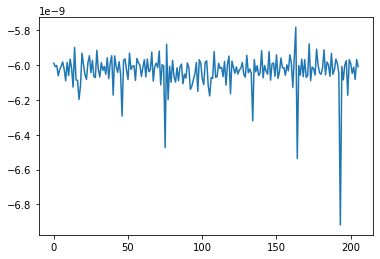

In [47]:
# the units of this is unknown ? 
plt.plot(latmandata.current)

In [257]:
def get_atom_that_moved_the_most(old_centroids, CC):
    Cim = np.array(CC.stm.scandata(1,4))
    zconst = float(CC.stm.getparam('ZPiezoConst'))
    nmx = nmy = CC.get_len_nm()
    C = CircCorral(Cim, zconst, nmx, nmy)
    C.subtract_plane()
    C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)
    
    sorted_new = np.array(sorted(C.centroids, key=lambda x:x[0]**2+x[1]**2))
    sorted_old = np.array(sorted(old_centroids, key=lambda x:x[0]**2+x[1]**2))
    
    cost_matrix = cdist(sorted_old, sorted_new)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    sorted_new = sorted_new[col_ind,:]
    sorted_old = sorted_old[row_ind,:]
    
    norm = np.linalg.norm(sorted_old-sorted_new, axis=-1)
    largest_move_index = np.argmax(norm)
    
    if C.pix_to_nm(np.max(norm)) < 0.2:
        print("atom did not move")
        return False, False
    
    central_atom_loc = sorted_new[largest_move_index]
    
    original_circle = C.nsphere_fit(np.delete(sorted_new,largest_move_index, axis=0))
    
    plt.imshow(C.im)
    plt.scatter(*central_atom_loc)
    plt.show()
    return central_atom_loc, original_circle

In [258]:
def get_latman_dest(circle, C, safety_distance_nm):
    safe_dist_px = C.nm_to_pix(safe_dist_nm)
    safe_radius = circle[0] - safe_dist_px

    # randomly sample in a circle of this radius and convert to cartesian coords 
    r = safe_radius * np.sqrt(random.random())
    theta = random.random()*2*np.pi
    x = circle[1][0] + r * np.cos(theta)
    y = circle[1][0] + r * np.sin(theta)

    # destination for the atom
    dest = [x, y]
    return dest 

	17 centroids
47 66 67 44
	17 centroids


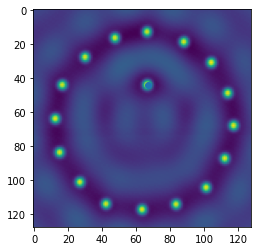

	17 centroids
67 44 91 77
	17 centroids


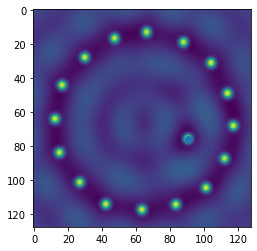

	17 centroids
91 76 77 69
	17 centroids


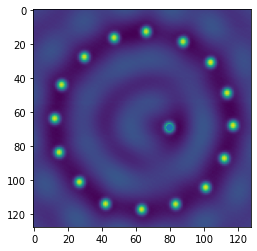

	17 centroids
80 69 31 55
	17 centroids


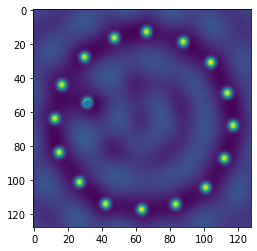

	17 centroids
31 54 93 48
	17 centroids


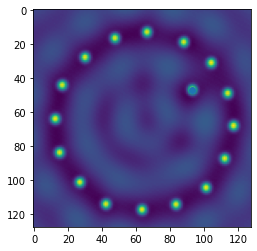

	17 centroids
93 47 96 88
	17 centroids


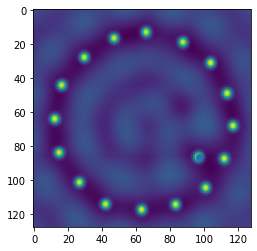

	17 centroids
97 86 65 92
	17 centroids


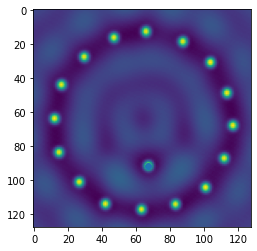

	17 centroids
67 92 49 26
	17 centroids


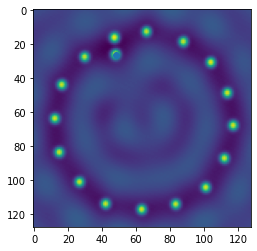

	17 centroids
48 26 100 66
	17 centroids


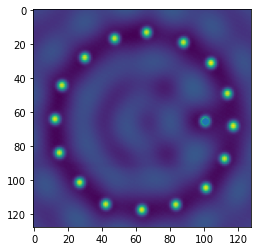

	17 centroids
101 65 45 64
	17 centroids


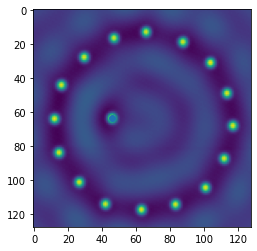

	17 centroids
46 64 48 80
	17 centroids


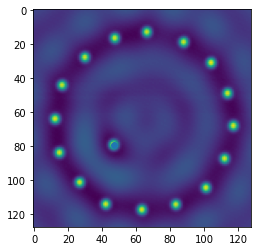

	17 centroids
47 79 57 43
	17 centroids


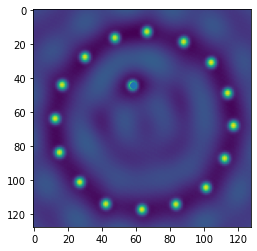

	17 centroids
58 44 48 49
	17 centroids


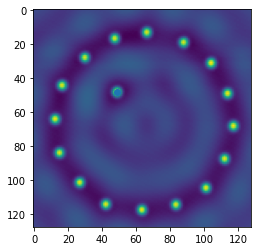

	17 centroids
49 48 60 46
	17 centroids


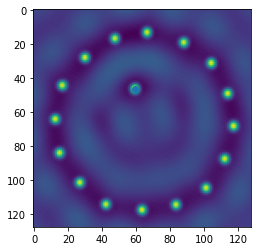

	17 centroids
59 46 82 35
	17 centroids


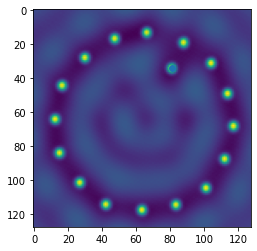

	17 centroids
81 34 33 45
	17 centroids


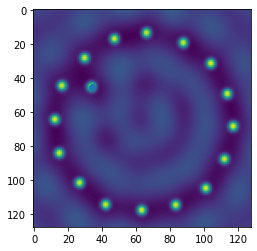

	17 centroids
34 45 36 47
	17 centroids


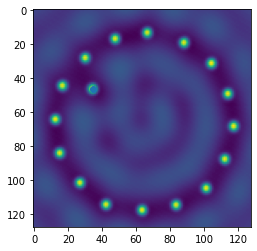

	17 centroids
34 46 87 55
	17 centroids


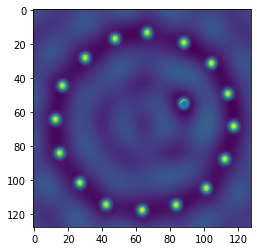

	17 centroids
88 55 74 81
	17 centroids


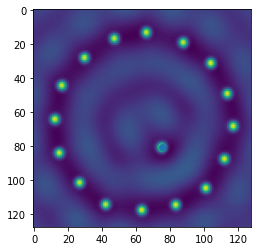

	17 centroids
75 81 78 72
	17 centroids


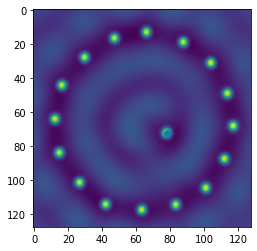

	17 centroids
78 72 70 84
	17 centroids


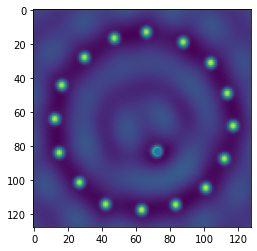

	17 centroids
72 83 45 42
	17 centroids


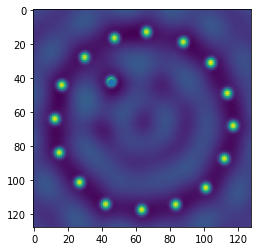

	17 centroids
45 42 74 83
	17 centroids


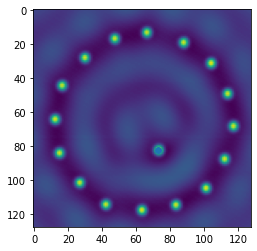

	17 centroids
73 82 60 93
	17 centroids


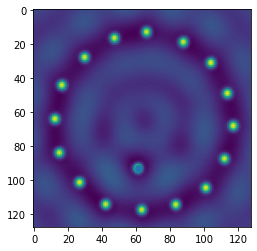

	17 centroids
61 93 101 61
	17 centroids


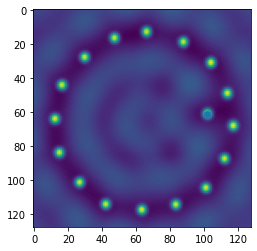

	17 centroids
102 61 73 66
	17 centroids


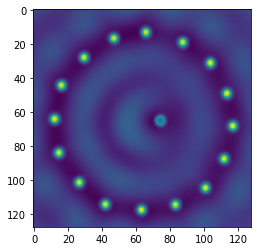

	17 centroids
74 65 99 88
	17 centroids


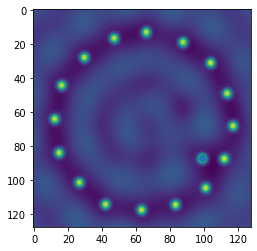

	17 centroids
99 87 89 78
	17 centroids


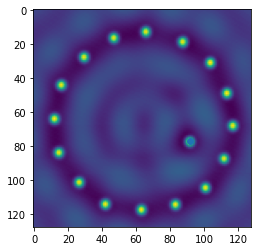

	17 centroids
92 77 74 24
	17 centroids


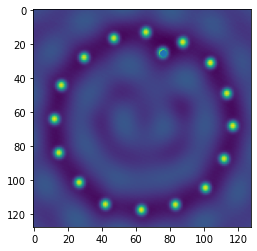

	17 centroids
76 25 44 73
	17 centroids


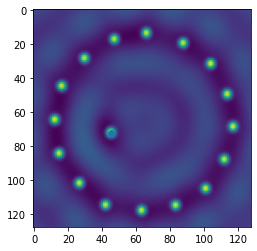

	17 centroids
45 72 77 82
	17 centroids


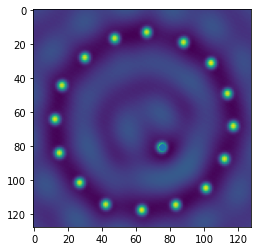

	17 centroids
75 81 96 42
	17 centroids


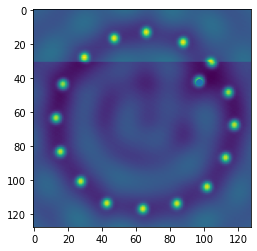

	17 centroids
97 42 36 81
	17 centroids


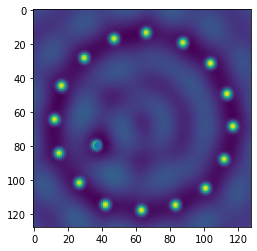

	17 centroids
37 79 101 72
	17 centroids


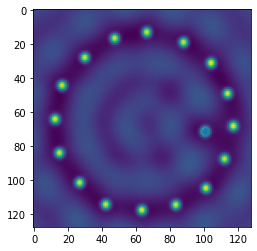

	17 centroids
101 71 22 63
	17 centroids


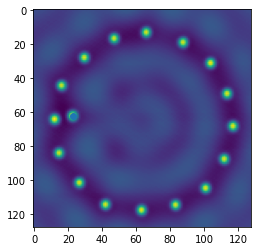

	17 centroids
23 62 59 72
	17 centroids


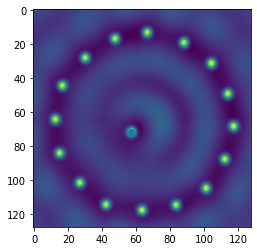

	17 centroids
57 72 62 78
	17 centroids


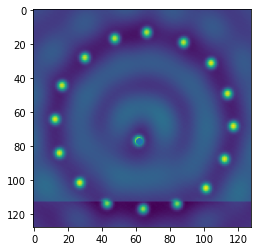

	17 centroids
62 77 66 49
	17 centroids


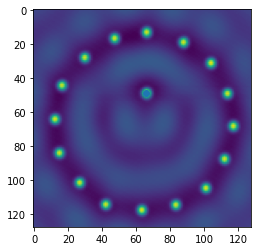

	17 centroids
66 49 30 68
	17 centroids


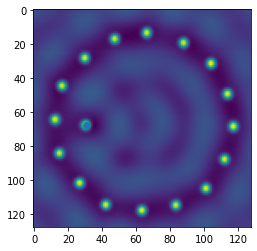

	17 centroids
30 68 73 92
	17 centroids


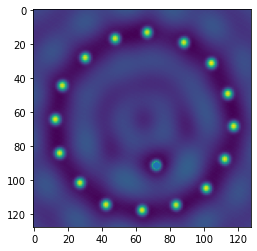

	17 centroids
72 91 97 70
	17 centroids


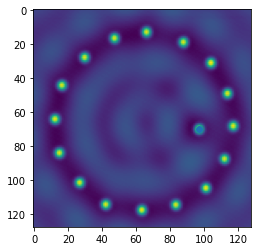

	17 centroids
97 70 64 40
	17 centroids


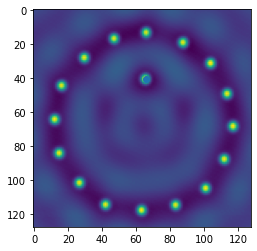

	17 centroids
66 41 96 92
	17 centroids


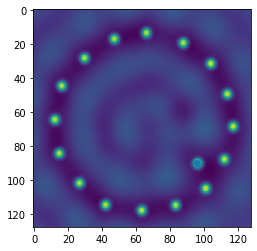

	17 centroids
96 90 42 41
	17 centroids


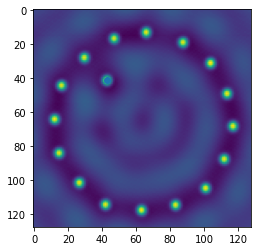

	17 centroids
43 41 95 83
	17 centroids


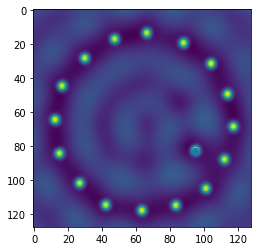

	17 centroids
95 83 88 70
	17 centroids


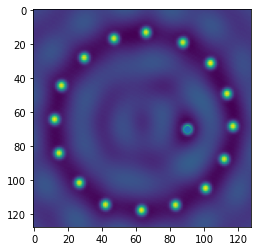

	17 centroids
90 70 94 37
	17 centroids


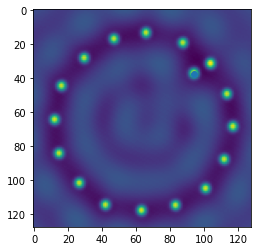

	17 centroids
94 37 96 89
	17 centroids


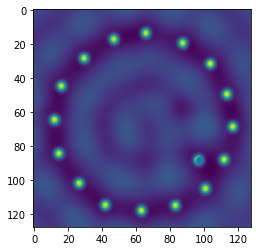

	17 centroids
97 88 98 62
	17 centroids


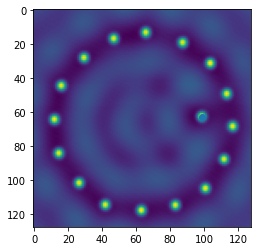

	17 centroids
99 63 98 41
	17 centroids


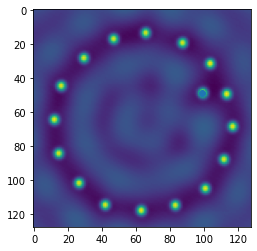

	17 centroids
99 49 102 69
	17 centroids


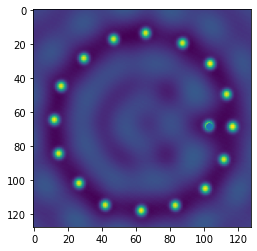

	17 centroids
103 68 70 28
	17 centroids


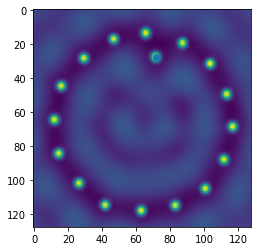

	17 centroids
72 28 54 94
	17 centroids


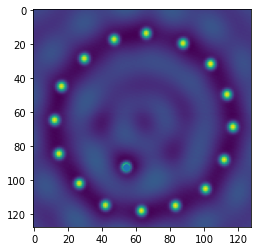

	17 centroids
54 92 55 26
	17 centroids


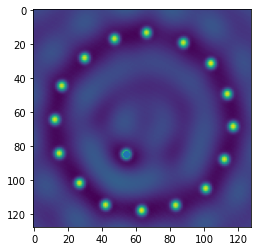

	17 centroids
54 85 66 54
	17 centroids


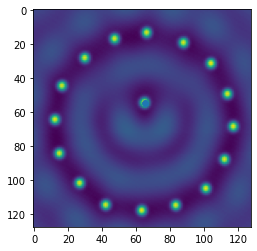

	17 centroids
65 54 80 92
	17 centroids


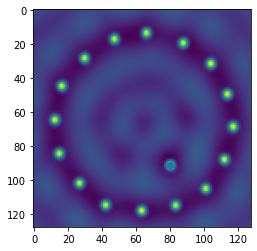

	17 centroids
80 91 47 69
	17 centroids


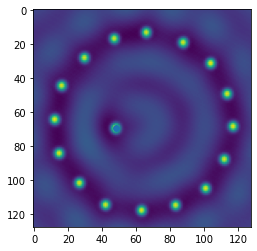

	17 centroids
48 70 69 46
	17 centroids


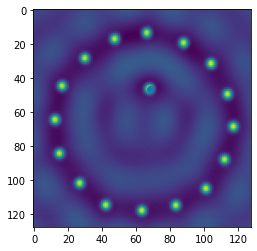

	17 centroids
68 46 94 77
	17 centroids


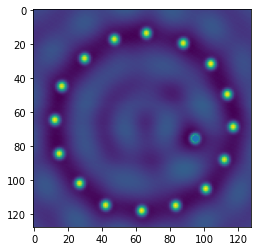

In [ ]:
import pdb, time

# get atoms at beginning
Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)
central_atom_loc = C.get_central_atom(C.centroids)

old_centroids = C.centroids
original_circle = C.r, C.c
    
safe_dist_nm = 1.2
latman_millivolt = 3
latman_picoamp = 80000
scan_bias_mv = 40
spec_bias_mv = 40


offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

CC.ramp_bias_mV(spec_bias_mv)
CC.stm.btn_vertspec(*central_atom_loc)
CC.stm.vertsave()

while True:
    # get a destination within the circle to move the atom 
    dest = get_latman_dest(original_circle, C, safe_dist_nm)
    
    # convert to nm 
    init = pixel_to_nm(central_atom_loc, Cim, offset_nm, [nmx, nmy])
    final = pixel_to_nm(dest, Cim, offset_nm, [nmx, nmy])

    # do the manipulation
    latmandata = CC.lat_manipulation(*init, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
    
    # scan corral 
    CC.ramp_bias_mV(scan_bias_mv)
    CC.stm.scanstart()
    CC.stm.scanwaitfinished()
    time.sleep(1)
    CC.stm.quicksave()
    
    # get position of atom that has moved the most since last scan
    central_atom_loc_old, original_circle_old = central_atom_loc, original_circle
    central_atom_loc, original_circle = get_atom_that_moved_the_most(old_centroids, CC)
    
    # if the atom hasn't moved, try again (i.e move to the top of the while loop)
    if central_atom_loc is False:
        central_atom_loc, original_circle = central_atom_loc_old, original_circle_old
        continue 
    
    # take spectrum on that atom and save it
    CC.ramp_bias_mV(spec_bias_mv)
    CC.stm.btn_vertspec(*central_atom_loc)
    CC.stm.vertsave()
 
    # set the current atom locations as the "old" atom locations for next loop
    Cim = np.array(CC.stm.scandata(1,4))
    C = CircCorral(Cim, zconst, nmx, nmy)
    C.subtract_plane()
    C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)
    old_centroids = C.centroids